In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from pathlib import Path  

# Let's start by importing the necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
# import plot_partial_dependence
# from sklearn.inspection import plot_partial_dependence
# import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trf = pd.read_csv('../../data/tidy/tti-traffic19-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/acs19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
pop = pd.read_csv('../../data/tidy/acs19-pop.csv')

In [3]:
df = trf.merge(net, left_on='msa', right_on='msa', how='left')
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.dropna(subset=['tti'])
# df['log_tti'] = np.log10(df['tti'])
df = df.set_index('msa')
df.to_csv('../../data/tidy/congestion-exploration_MM.csv', index = False)
# df

In [4]:

# reset index and drop old index
df.reset_index(inplace=True)
# drop msa
df.drop('msa', axis=1, inplace=True)
data = df.copy()


data.head()


,auto_commuters,annual_excess_fuel_consumed_commuters,ahd,tti,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,...,ms_cara,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,households,med_hh_inc_dol
0,62,788,1694,1.06,14357,39401,5.488751,1.716897e+07,435.749497,2.881452,...,0.806459,0.117276,0.006420,0.017641,0.002089,0.024034,0.026081,6.4,60343,44249
1,298,6453,14470,1.11,26865,70900,5.278243,1.519199e+07,214.273426,2.756896,...,0.862746,0.066992,0.014979,0.005027,0.001327,0.016849,0.032080,9.7,281752,50776
2,53,810,1752,1.07,8466,22838,5.395228,9.545102e+06,417.948256,2.837468,...,0.804208,0.123413,0.010765,0.007939,0.001490,0.019618,0.032567,15.0,58250,36805
3,300,5172,13605,1.14,36977,96867,5.239311,2.787244e+07,287.739291,2.755794,...,0.804724,0.076936,0.032160,0.009713,0.002339,0.036837,0.037290,7.4,347401,61841
4,380,8950,18864,1.15,56267,139711,4.966001,4.185019e+07,299.548265,2.720333,...,0.799726,0.095175,0.018131,0.013973,0.009816,0.018735,0.044445,9.1,344168,48875


# Create train test sets

In [5]:
# Splitting the data into features and target variable
features = data.drop('tti', axis=1)
target = data['tti']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Apply Principal Component Analysis (PCA) to the training set

In [6]:

# Applying PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Creating a dataframe to hold the PCA components and the contribution of each feature to them
pca_components = pd.DataFrame(pca.components_, columns=features.columns)

# Checking the first few rows of the PCA components dataframe
pca_components.head()


,auto_commuters,annual_excess_fuel_consumed_commuters,ahd,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,...,ms_cara,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,households,med_hh_inc_dol
0,0.000020,0.000894,0.002228,0.001839,0.004639,-1.250514e-09,0.876198,-1.190782e-06,3.368083e-10,0.001462,...,-4.792203e-10,-8.024882e-11,5.617487e-10,-2.998825e-13,-1.521363e-11,-4.768458e-11,6.091849e-11,-3.536406e-09,0.021035,0.000109
1,0.000567,0.036557,0.092900,0.022031,0.057339,4.632324e-08,-0.396942,-4.627048e-05,6.371886e-08,0.020223,...,-2.720355e-08,1.156580e-09,2.054339e-08,1.019490e-09,1.115359e-09,4.133415e-09,-7.646780e-10,6.084196e-07,0.586055,0.001791
2,-0.000588,-0.049212,-0.118939,-0.008588,-0.028758,-2.671593e-08,-0.272878,8.784047e-07,6.080759e-08,-0.006186,...,5.604020e-08,1.013621e-08,-5.055534e-08,1.618911e-09,-2.177498e-09,-1.284892e-08,-2.213563e-09,-4.315382e-07,-0.790380,-0.002109
3,0.004375,0.307874,0.925800,-0.045870,-0.124000,1.366955e-07,0.000147,6.358118e-04,-2.664784e-08,-0.050958,...,1.887552e-07,7.980453e-08,-2.486316e-07,7.534265e-09,1.983008e-09,-3.020010e-08,7.547774e-10,-4.854652e-06,-0.149870,-0.016474
4,0.002776,0.034830,0.141905,0.346503,0.784093,-3.259238e-06,0.015538,-3.212235e-03,-1.615299e-06,0.230534,...,5.260752e-08,-5.104039e-08,-2.874508e-08,-1.102020e-08,3.004489e-08,-1.041436e-07,1.122969e-07,2.433605e-05,-0.093582,0.044373


# Implement a Gradient Boosting Machine (GBM) model on this PCA-transformed data

##  Before fitting the model, run a grid search to find the best parameters for the GBM

In [7]:
# Applying PCA transformation to test data
X_test_pca = pca.transform(X_test)

# Defining the parameters for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initializing the GBM model
gbm = GradientBoostingRegressor(random_state=42)

# Running the grid search
grid_search = GridSearchCV(gbm, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Extracting the best parameters
best_params = grid_search.best_params_
best_params


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}

The best parameters obtained from the grid search are:

- Learning Rate: 0.1
- Max Depth: 4
- Number of Estimators: 300
- Subsample: 0.8

In [8]:
# Initializing the GBM model with the best parameters
best_gbm = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    random_state=42
)

# Fitting the model and making predictions
best_gbm.fit(X_train_pca, y_train)
y_pred = best_gbm.predict(X_test_pca)

# Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
# print rmse and mape
print(f'RMSE: {rmse:.2f} \nMAPE: {mape*100:.2f}%')


RMSE: 0.04 
MAPE: 2.55%


## The model's performance metrics
- Root Mean Squared Error (RMSE): 0.0449
- Mean Absolute Percentage Error (MAPE): 0.0268

# generate a feature importance plot and a partial dependence plot for the most important features

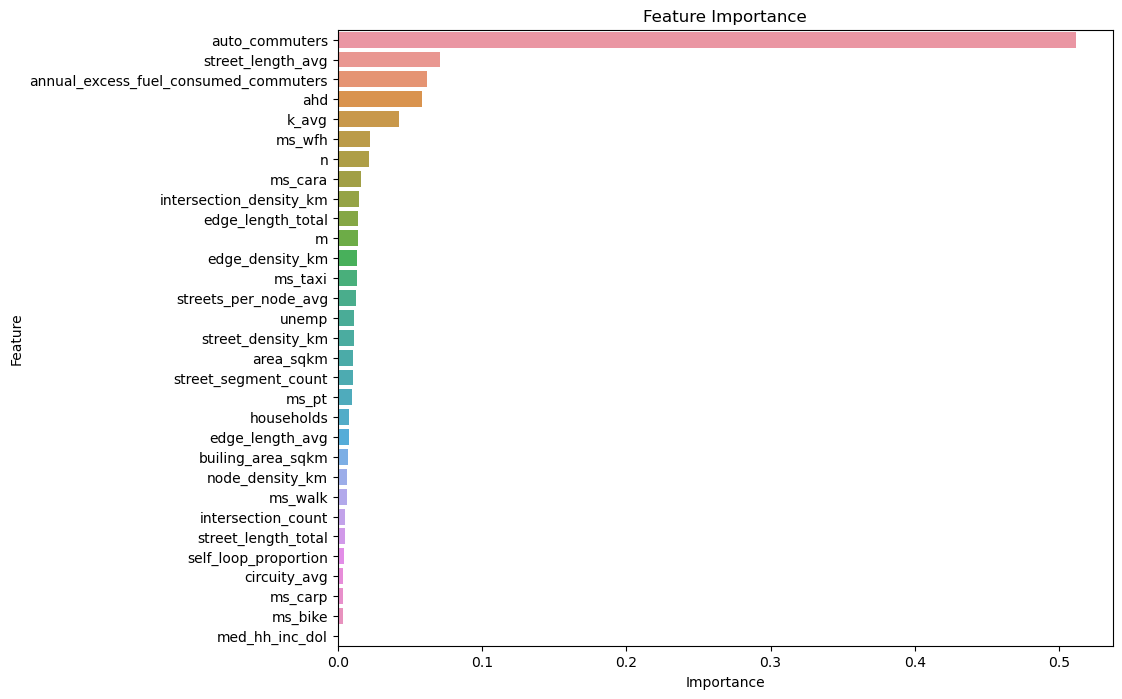

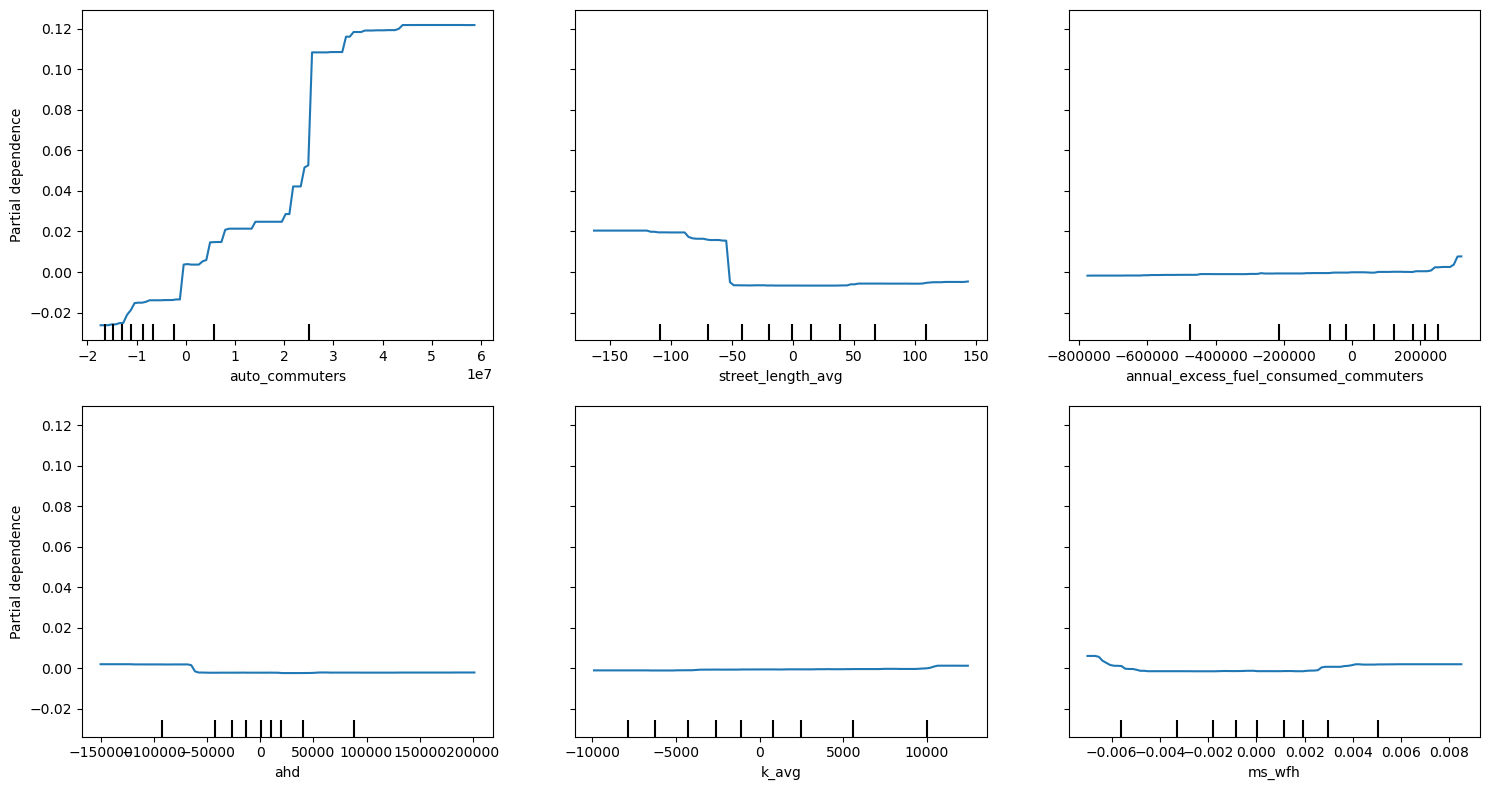

In [9]:
from sklearn.inspection import PartialDependenceDisplay
# Extracting feature importances and their corresponding names
feature_importances = best_gbm.feature_importances_
feature_names = features.columns

# Creating a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sorting the DataFrame based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Creating a bar plot for feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Selecting the top 5 most important features for the partial dependence plot
top_features = importance_df['Feature'].head(6)

# Generating the partial dependence plots
# plot_partial_dependence(best_gbm, X_train_pca, features=top_features, feature_names=feature_names)
# use PartialDependenceDisplay instead of plot_partial_dependence 
fig, ax = plt.subplots(figsize=(15, 8))
display = PartialDependenceDisplay.from_estimator(best_gbm, X_train_pca, features=top_features, feature_names=feature_names, ax=ax)
# display.plot(ax=ax)
plt.tight_layout()
plt.savefig('../../figures/PCA')
plt.show()


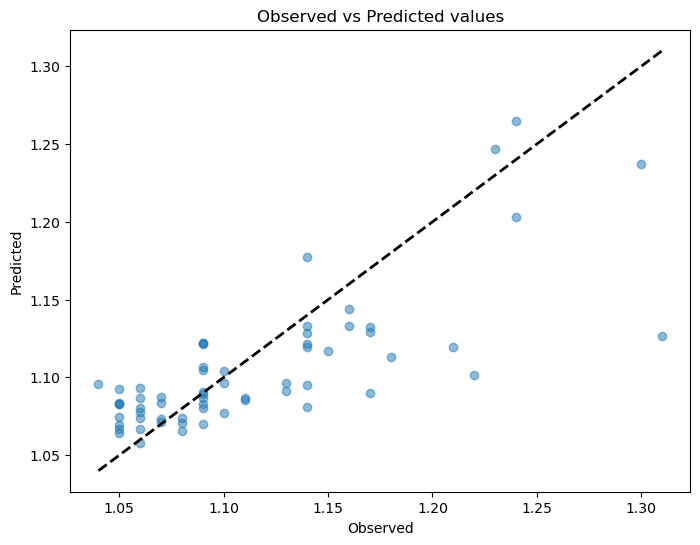

In [10]:
# Creating a scatter plot for observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted values')
plt.show()



-------------
-------------
-------------

# 2. Try:
- RFE (feature selection)
- Remove pca
- Use GBM



In [11]:
target = 'tti'
features = [col for col in df.columns if col != target]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# 1. Do grid search for GBM

In [12]:
# Applying PCA transformation to test data
# X_test_pca = pca.transform(X_test)

# Defining the parameters for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Initializing the GBM model
gbm = GradientBoostingRegressor(random_state=42)

# Running the grid search
grid_search = GridSearchCV(gbm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 0.5,
 'n_estimators': 200,
 'subsample': 0.8}

In [13]:

gbm = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    max_features=best_params['max_features'],
    random_state=42
)


## 2. Use Recursive Feature Elimination (RFE) to select the most important features.

In [14]:
from sklearn.feature_selection import RFE


target = 'tti'
features = [col for col in df.columns if col != target]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=12)

# Define the RFE 
rfe = RFE(estimator=gbm, n_features_to_select=10)  # selecting the top 10 features

# Fit the RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [f for f, s in zip(features, rfe.support_) if s]
selected_features

['auto_commuters',
 'annual_excess_fuel_consumed_commuters',
 'ahd',
 'street_length_avg',
 'circuity_avg',
 'ms_cara',
 'ms_carp',
 'ms_pt',
 'households',
 'med_hh_inc_dol']

## 3. Train a Gradient Boosting Machine (GBM) model with the selected features

In [15]:
# Re-define the training and testing sets based on the selected features
X_train, X_test = X_train[selected_features], X_test[selected_features]
# Fit the GBM to the training data
gbm.fit(X_train, y_train)


GradientBoostingRegressor(max_features=0.5, n_estimators=200, random_state=42,
                          subsample=0.8)

# 4. Plot the feature importance, partial dependence, and observed vs. predicted values

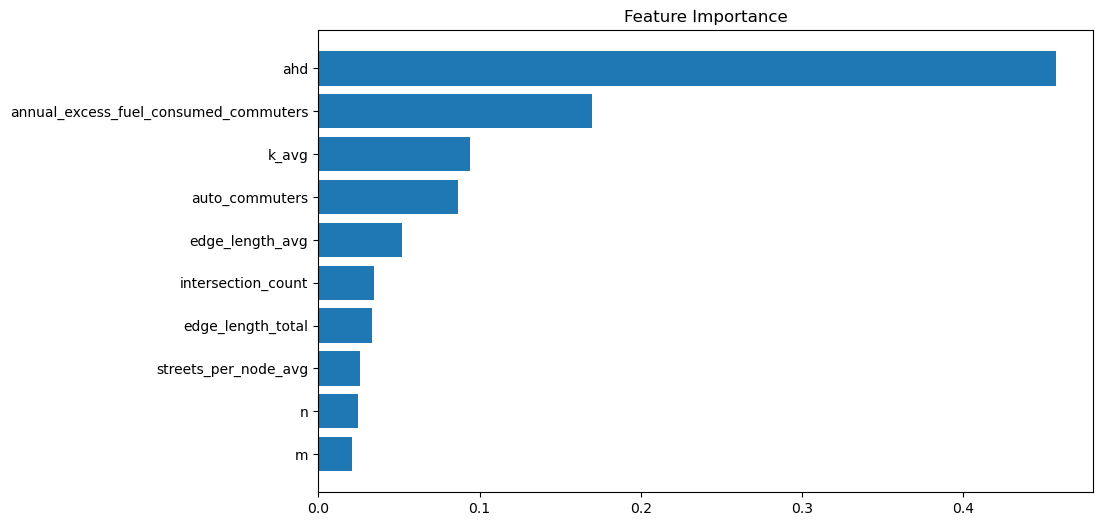

In [16]:
# Get feature importances
importances = gbm.feature_importances_

# Sort the features by importance
sorted_idx = np.argsort(importances)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), np.array(features)[sorted_idx])
plt.title('Feature Importance')
plt.show()


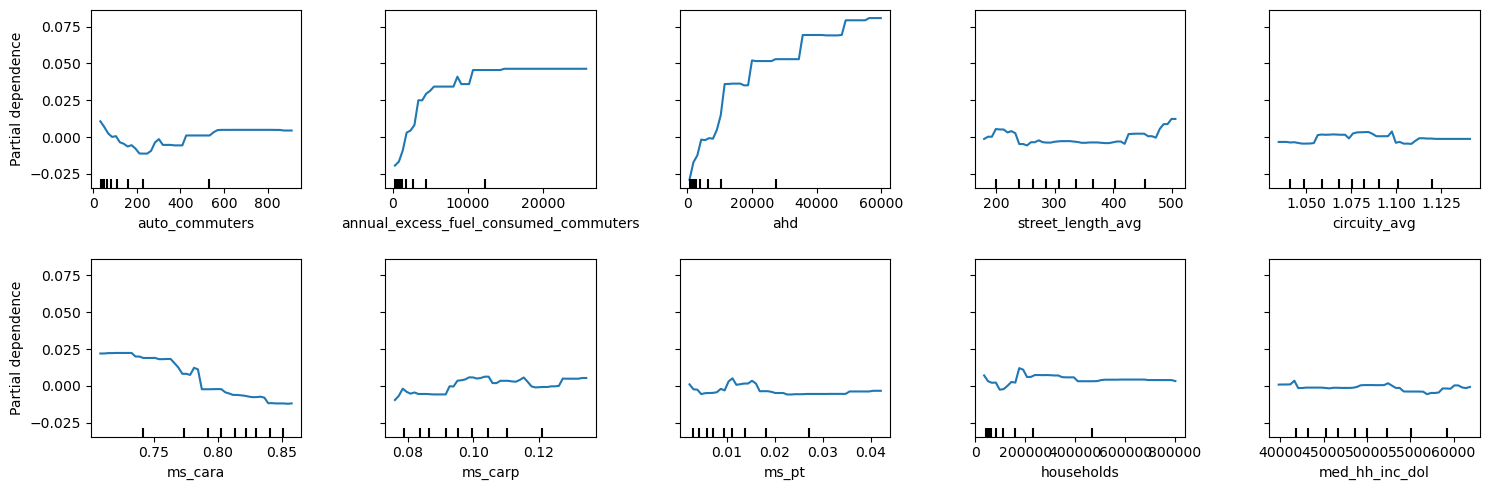

In [17]:
# plot partial dependance using PartialDependenceDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# get the feature names
feature_names = X_train.columns

# plot partial dependence
fig, ax = plt.subplots(figsize=(15, 5))
display = PartialDependenceDisplay.from_estimator(
    gbm, X_train, features=feature_names, ax=ax, n_cols=5, grid_resolution=50
)
# display.plot(cmap='viridis')
# increase spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.savefig('../../figures/GBM')
plt.show()


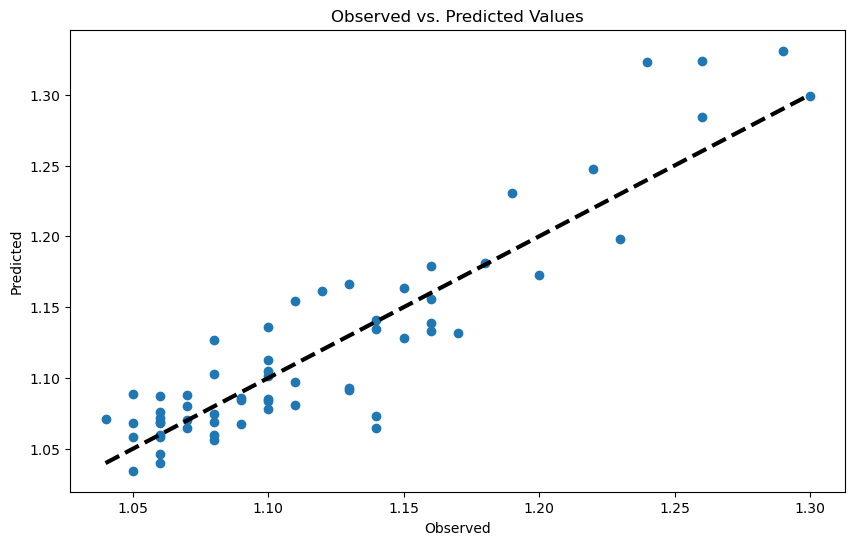

In [18]:
# Get predictions
y_pred = gbm.predict(X_test)

# Plot observed vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs. Predicted Values')
plt.show()


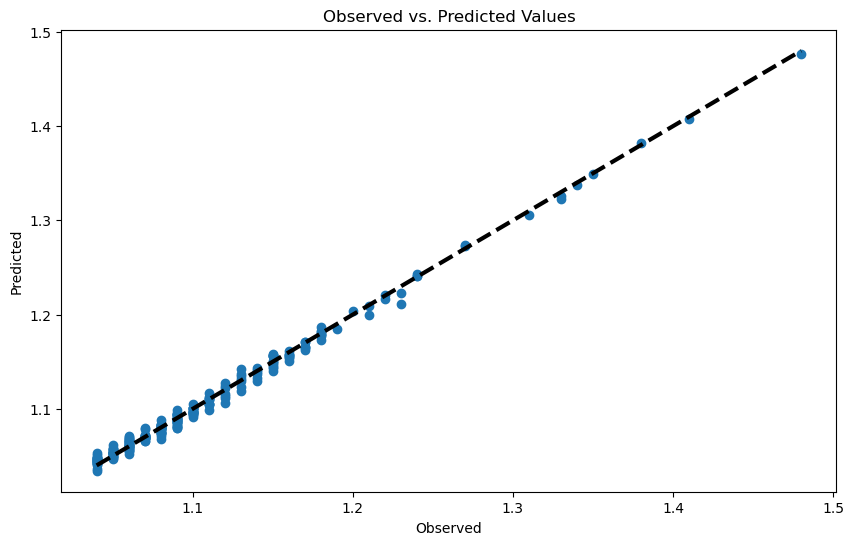

In [19]:
# Get predictions
y_pred_train = gbm.predict(X_train)

# Plot observed vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs. Predicted Values')
plt.show()

# 5. Compute the Root Mean Square Error (RMSE) and the Mean Absolute Percentage Error (MAPE)

In [20]:
# Compute the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Compute the MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE: {mape}%')


RMSE: 0.029073845957682986
MAPE: 1.9872509055336403%


----------------
----------------    
----------------

# 3. Try:
- RFE (feature selection)
- Remove pca
- Use Generalized Linear Model (GLM)

In [21]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

data = df.copy()

# Set the target variable and predictor variables
target = 'tti'
predictors = [col for col in data.columns if col != target]

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Check the shape of the training and test sets
train_data.shape, test_data.shape

((214, 32), (93, 32))

# 1. Do grid search for GLM

In [22]:
# Applying PCA transformation to test data
# # X_test_pca = pca.transform(X_test)

# # Defining the parameters for the grid search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1],
#     'max_depth': [3, 4],
#     'subsample': [0.8, 0.9, 1.0],
#     'max_features': [0.5, 0.8, 1.0]
# }

# # Initializing the GBM model
# gbm = GradientBoostingRegressor(random_state=42)

# # Running the grid search
# grid_search = GridSearchCV(gbm, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Extracting the best parameters
# best_params = grid_search.best_params_
# best_params

# 2. Select the most important features using RFE

In [23]:
# Initialize an instance of the linear regression model
lr = LinearRegression()

# Initialize an RFE instance, specifying that we want to end up with 10 features
rfe = RFE(lr, n_features_to_select=10)

# Fit the RFE instance on the training data
rfe.fit(train_data[predictors], train_data[target])

# Get the features selected by RFE
selected_features = np.array(predictors)[rfe.support_]

selected_features


array(['k_avg', 'streets_per_node_avg', 'self_loop_proportion', 'ms_cara',
       'ms_carp', 'ms_pt', 'ms_taxi', 'ms_bike', 'ms_walk', 'ms_wfh'],
      dtype='<U37')

In [24]:
# Fit a GLM on the training data using only the selected features
GLM = sm.GLM(train_data[target], sm.add_constant(train_data[selected_features])).fit()

# Make predictions on the test data
predictions = GLM.predict(sm.add_constant(test_data[selected_features]))

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_data[target], predictions))
mape = mean_absolute_percentage_error(test_data[target], predictions)

rmse, mape


(0.05342638454503932, 0.03429087405558029)

The RMSE = 0.053
and MAPE = 3.4%

# 3. Plots

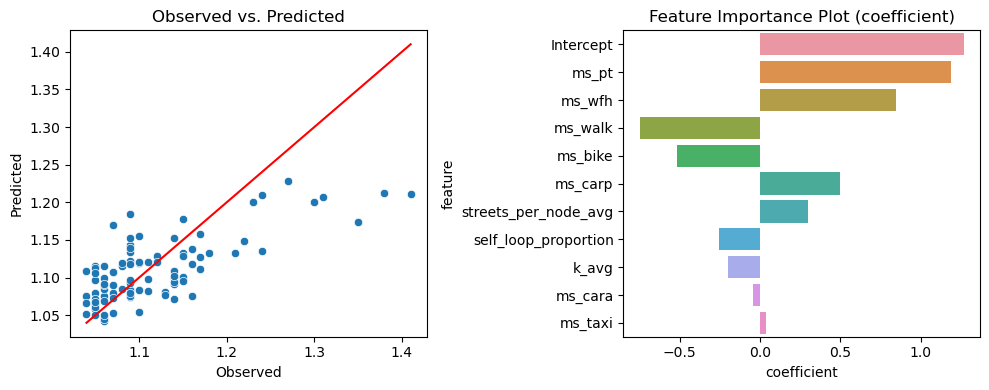

In [25]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Observed vs. predicted plot
sns.scatterplot(x=test_data[target], y=predictions, ax=axes[0])
axes[0].plot([min(test_data[target]), max(test_data[target])], [min(test_data[target]), max(test_data[target])], color='red') # 45-degree line
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Observed vs. Predicted')

# Feature importance (coefficient) plot
coefs = pd.DataFrame({'feature': ['Intercept'] + list(selected_features), 'coef': GLM.params})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs = coefs.sort_values('abs_coef', ascending=False)
sns.barplot(x='coef', y='feature', data=coefs, ax=axes[1])
axes[1].set_title('Feature Importance Plot (coefficient)')
axes[1].set_xlabel('coefficient')
axes[1].set_ylabel('feature')

plt.tight_layout()
plt.savefig('../../figures/GLM')
plt.show()


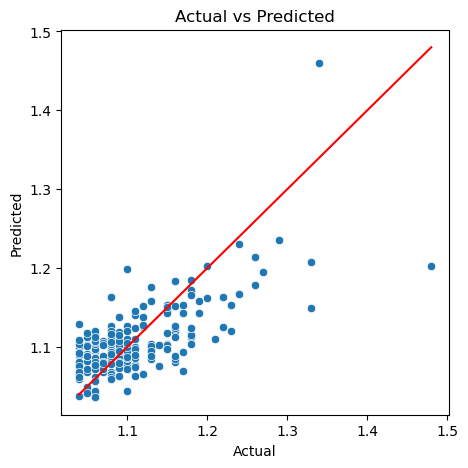

In [26]:
# Make predictions on the train data
predictions_ = GLM.predict(sm.add_constant(train_data[selected_features]))
# plot one plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=train_data[target], y=predictions_, ax=ax)
# plot the line
sns.lineplot(x=train_data[target], y=train_data[target], ax=ax, color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')
plt.show()

# plot two plot

----------------
----------------    
----------------

# 4. Try:
- Use RFE (feature selection)
- Remove pca
- Use GAM

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = df.copy()


In [42]:
# Define the predictor and target variables
X = data.drop('tti', axis=1)
y = data['tti']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 1. Use RFE

In [43]:
# Define the model
model = LinearRegression()

# Perform RFE
rfe = RFE(estimator=model, n_features_to_select=10) 
fit = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[fit.support_]
selected_features

Index(['k_avg', 'streets_per_node_avg', 'self_loop_proportion', 'ms_cara',
       'ms_carp', 'ms_pt', 'ms_taxi', 'ms_bike', 'ms_walk', 'ms_wfh'],
      dtype='object')

# 2. Fit a Generalized Additive Model (GAM) using the selected features

In [44]:
# Create a new training set with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define the GAM
gam = LinearGAM(n_splines=10, lam=0.8).gridsearch(X_train_selected.values, y_train.values)
# n_splines: number of splines to use which signifies the number of basis functions that will be used to fit the data
# lam: the regularization parameter which controls the smoothness of the fit (the higher the value, the smoother the fit, and the lower the value, the more complex the fit, and the more likely to overfit)


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


# 3. Plot the feature importance, partial dependence, and observed vs. predicted

In [45]:
# # Feature importance

# # for i, feature in enumerate(selected_features):
# #     plt.figure()
# #     plt.plot(gam.partial_dependence(term=i, X=X_train_selected.values))
# #     plt.title(f'Partial dependence for feature {feature}')
# #     plt.show()

# # plot on a single graph for comparison using subplots 
# fig, axs = plt.subplots(3, 10, figsize=(20, 10))
# for i, ax in enumerate(axs.ravel()):
#     if i < len(selected_features):
#         ax.plot(gam.partial_dependence(term=i, X=X_train_selected.values))
#         ax.set_title(f'{selected_features[i]}')
#         # ax.set_ylim(-1, 1)
#     else:
#         ax.set_axis_off()

# plt.tight_layout()

# plt.show()


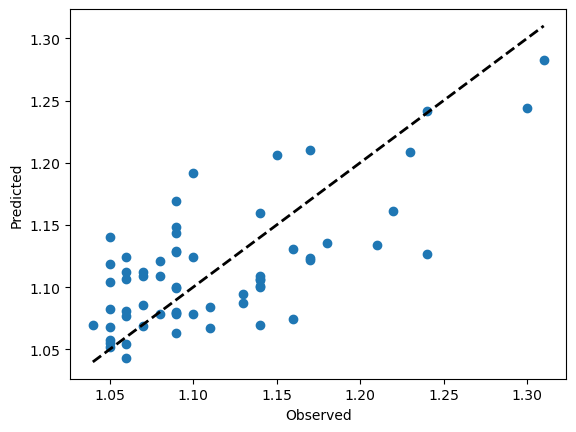

In [46]:

# Observed vs predicted plot
plt.figure()
predicted_values = gam.predict(X_test_selected.values)
plt.scatter(y_test, predicted_values)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.savefig('../../figures/GAM')
plt.show()


4. Errors

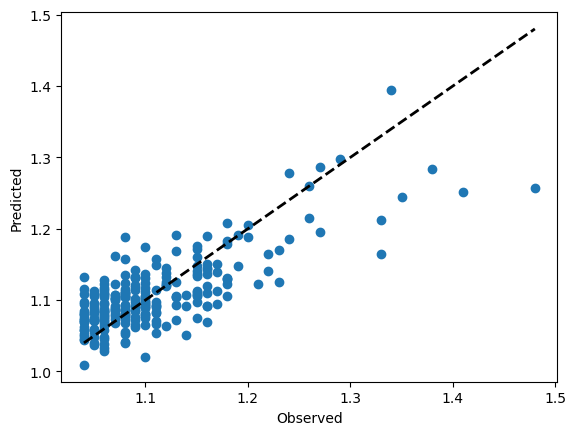

In [47]:
# plot observed vs predicted using terainin data
plt.figure()
predicted_values = gam.predict(X_train_selected.values)
plt.scatter(y_train, predicted_values)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

In [48]:
# Calculate the errors
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MAPE: ', mape)
# print('MSE: ', mse)
print('RMSE: ', rmse)


MAPE:  5.894247506122337
RMSE:  0.09083240423839635
